# Basic Demo for D-Wave in Braket: The Maximum-Cut Problem

In this tutorial we solve a small instance of the famous __Maximum-Cut (MaxCut)__ Problem using the D-Wave backend on Amazon Braket. The MaxCut problem is one of the most famous NP-hard problems in combinatorial optimization. Given an undirected graph $G(V, E)$ with a vertex set $V$ and an edge set $E$, the Max Cut problem seeks to partition $V$ into two sets such that the number of edges between the two sets (considered to be severed by the cut), is a large as possible. Applications can be found (for example) in clustering problems for marketing purposes or portfolio optimization problems in finance. 

Disclaimer: The code shown in this example has been taken from D-Wave tutorial availbale online [here]( https://github.com/dwave-examples/maximum-cut), with copyright to D-Wave Systems, Inc., licensed under the Apache License. The purpose of this example is to show how existing code using D-Wave's Ocean tool suite can easily be run on Amazon Braket, with minimal code changes. 

In [1]:
import boto3
import json
from braket.aws import AwsSession, AwsQpu
from braket.ocean_plugin import BraketSamplerArns, BraketSampler, BraketDWaveSampler

In [2]:
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import networkx as nx
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

__NOTE__: Please enter your S3 bucket and key below. 

In [3]:
# set up S3 bucket (where results are stored)
my_bucket = "braket-bravehearts"
my_prefix = "dwave-output"
s3_folder = (my_bucket, my_prefix)

In [4]:
# session and backend
aws_session = AwsSession()
device = AwsQpu("arn:aws:aqx:::qpu:d-wave")
print('Device backend:', device)

Device backend: QPU('name': D-Wave, 'arn': arn:aws:aqx:::qpu:d-wave)


## SETTING UP THE MAXCUT PROBLEM 

In [5]:
# helper function to plot graph
def get_graph(graph, pos):
    """
    plot colored graph for given solution
    """
    # positions for all nodes
    # pos = nx.spring_layout(graph)

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

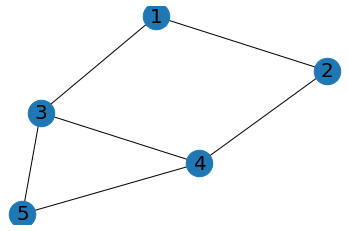

In [6]:
# Copyright 2019 D-Wave Systems, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ------ Import necessary packages ----
from collections import defaultdict

# from dwave.system.samplers import DWaveSampler
# from dwave.system.composites import EmbeddingComposite

# ------- Set up our graph -------

# Create empty graph
G = nx.Graph()

# Add edges to the graph (also adds nodes)
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])

# plot graph
pos = nx.spring_layout(G)
# plot graph with labels
get_graph(G, pos)

# ------- Set up our QUBO dictionary -------

# Initialize our Q matrix
Q = defaultdict(int)

# Update Q matrix for every edge in the graph
for u, v in G.edges:
    Q[(u,u)]+= -1
    Q[(v,v)]+= -1
    Q[(u,v)]+= 2

# print Q matrix
# print('Show Q matrix:', Q)

## SOLVING THE MAXCUT PROBLEM ON DWAVE

------------------------------------------------------------
          Set 0          Set 1    Energy        Cut Size    
------------------------------------------------------------
      [1, 4, 5]         [2, 3]     -5.0             5       
         [2, 3]      [1, 4, 5]     -5.0             5       
      [1, 2, 5]         [3, 4]     -4.0             4       
         [3, 4]      [1, 2, 5]     -4.0             4       
      [1, 3, 4]         [2, 5]     -4.0             4       
      [1, 2, 3]         [4, 5]     -3.0             3       
      [1, 2, 4]         [3, 5]     -3.0             3       
   [1, 2, 4, 5]            [3]     -3.0             3       

Your plot is saved to maxcut_plot.png


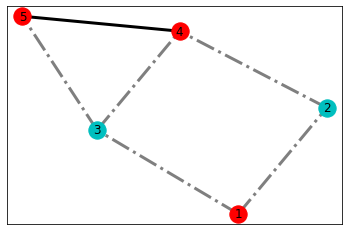

In [7]:
# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
chainstrength = 8
numruns = 10

# Run the QUBO on the Braket solver from your config file
# set sampler
sampler = BraketDWaveSampler(s3_folder, BraketSamplerArns.DWAVE)
sampler = EmbeddingComposite(sampler)
response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
energies = iter(response.data())

# ------- Print results to user -------
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for line in response:
    S0 = [k for k,v in line.items() if v == 0]
    S1 = [k for k,v in line.items() if v == 1]
    E = next(energies).energy
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int(-1*E))))

# ------- Display results to user -------
# Grab best result
# Note: "best" result is the result with the lowest energy
# Note2: the look up table (lut) is a dictionary, where the key is the node index
#   and the value is the set label. For example, lut[5] = 1, indicates that
#   node 5 is in set 1 (S1).
lut = response.lowest().first.sample

# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if not lut[node]]
S1 = [node for node in G.nodes if lut[node]]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)

filename = "maxcut_plot.png"
plt.savefig(filename, bbox_inches='tight')
print("\nYour plot is saved to {}".format(filename))

__DISCUSSION__: The optimal cut size for this toy problem is 5. For every edge connecting nodes of different color we score a point (i.e., cut this edge), as displayed above by dashed lines. Here at maximum we can cut five edges. In this toy example we find multiple optimal degenerate solutions, apart from the obvious $Z_{2}$ symmetry (i.e., the color choice for the two subsets is arbitrary), because there is no preferred coloring for node 5. This problem is equivalent to finding the antiferromagnetic ground state, in the presence of frustration (as present here in the subgraph with nodes 3-4-5). 

---
## APPENDIX

Original MaxCut example from here: https://github.com/dwave-examples/maximum-cut

In [8]:
# # Copyright 2019 D-Wave Systems, Inc.
# #
# # Licensed under the Apache License, Version 2.0 (the "License");
# # you may not use this file except in compliance with the License.
# # You may obtain a copy of the License at
# #
# #     http://www.apache.org/licenses/LICENSE-2.0
# #
# # Unless required by applicable law or agreed to in writing, software
# # distributed under the License is distributed on an "AS IS" BASIS,
# # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# # See the License for the specific language governing permissions and
# # limitations under the License.

# # ------ Import necessary packages ----
# from collections import defaultdict

# from dwave.system.samplers import DWaveSampler
# from dwave.system.composites import EmbeddingComposite
# import networkx as nx

# import matplotlib
# matplotlib.use("agg")
# from matplotlib import pyplot as plt

# # ------- Set up our graph -------

# # Create empty graph
# G = nx.Graph()

# # Add edges to the graph (also adds nodes)
# G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])

# # ------- Set up our QUBO dictionary -------

# # Initialize our Q matrix
# Q = defaultdict(int)

# # Update Q matrix for every edge in the graph
# for u, v in G.edges:
#     Q[(u,u)]+= -1
#     Q[(v,v)]+= -1
#     Q[(u,v)]+= 2

# # ------- Run our QUBO on the QPU -------
# # Set up QPU parameters
# chainstrength = 8
# numruns = 10

# # Run the QUBO on the solver from your config file
# sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
# response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
# energies = iter(response.data())

# # ------- Print results to user -------
# print('-' * 60)
# print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
# print('-' * 60)
# for line in response:
#     S0 = [k for k,v in line.items() if v == 0]
#     S1 = [k for k,v in line.items() if v == 1]
#     E = next(energies).energy
#     print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int(-1*E))))

# # ------- Display results to user -------
# # Grab best result
# # Note: "best" result is the result with the lowest energy
# # Note2: the look up table (lut) is a dictionary, where the key is the node index
# #   and the value is the set label. For example, lut[5] = 1, indicates that
# #   node 5 is in set 1 (S1).
# lut = response.lowest().first.sample

# # Interpret best result in terms of nodes and edges
# S0 = [node for node in G.nodes if not lut[node]]
# S1 = [node for node in G.nodes if lut[node]]
# cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
# uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# # Display best result
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
# nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
# nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
# nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
# nx.draw_networkx_labels(G, pos)

# filename = "maxcut_plot.png"
# plt.savefig(filename, bbox_inches='tight')
# print("\nYour plot is saved to {}".format(filename))